# ols_results_nav

In [1]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from glob import glob
import itertools
import warnings
from importlib import reload
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import patsy

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
# from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from helper_funcs import *
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, remapping, pop_decoding, time_cell_plots
from goldmine_replay import place_cells

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

data_dir = '/data7/goldmine'
proj_dir = '/home1/dscho/projects/time_cells'

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(data_dir, 'analysis', 'events', '*-Events.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [3]:
subj_sess = 'U532_ses0'
events = events_proc.load_events(subj_sess, verbose=False)
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)

# Set retrieval gold views to 0.
event_spikes.event_spikes.loc[(event_spikes.event_spikes['gameState']=='Retrieval') & 
                              (event_spikes.event_spikes['gold_in_view']==1), 'gold_in_view'] = 0

# Add a column to track how many golds were successfully dug on each trial.
golds_dug_per_trial = events.dig_events.query("(dig_success==True)").groupby('trial').size()
event_spikes.event_spikes.insert(4, 'gold_dug', event_spikes.event_spikes['trial'].apply(lambda x: golds_dug_per_trial.get(x, 0)))

print(event_spikes)

65 neurons



In [243]:
def run_ols_nav_parallel(subj_sess_unit):
    import sys
    import os
    sys.path.append('/home1/dscho/code/projects')
    from time_cells import time_bin_analysis
    
    proj_dir = '/home1/dscho/projects/time_cells'
    
    try:
        mod_pairs, ols_weights = time_bin_analysis.run_ols_nav(subj_sess_unit,
                                                               n_perm=1000,
                                                               alpha=0.05,
                                                               save_output=True,
                                                               overwrite=False)
    except:
        err = sys.exc_info()
        errf = '/home1/dscho/logs/TryExceptError-run_ols_nav_parallel-{}'.format(subj_sess_unit)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')

In [ ]:
# Get neurons to process.
fpath = op.join(proj_dir, 'analysis', 'unit_to_behav', '{}-Encoding_Retrieval-ols_model_pairs.pkl')
pop_spikes = pop_decoding.load_pop_spikes()
neurons = [neuron for neuron in pop_spikes.neurons if not op.exists(fpath.format(neuron))]
print('{} neurons to process'.format(len(neurons)))

# Parallel processing
n_ops = len(neurons)
print('Running code for {} operations.\n'.format(n_ops))
with cluster_view(scheduler="sge", queue="RAM.q", num_jobs=np.min((n_ops, 200)), cores_per_job=1) as view:
    output = view.map(run_ols_nav_parallel, neurons)

457 neurons to process
Running code for 457 operations.

200 Engines running


# Load mod_pairs, ols_weights

In [4]:
# Load processed OLS files.
mod_pairs_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Encoding_Retrieval-ols_model_pairs.pkl')
ols_weights_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Encoding_Retrieval-ols_weights.pkl')
mod_pairs = pd.concat([dio.open_pickle(f) for f in glob(mod_pairs_globstr)]).reset_index(drop=True)
ols_weights = pd.concat([dio.open_pickle(f) for f in glob(ols_weights_globstr)]).reset_index(drop=True)

# Drop rows.
drop_red = ['full-time,gameState:time', 'full-place,gameState:place',
            'fullMax-time,gameState:time', 'fullMax-place,gameState:place',
            'full+penalty-time:penalty', 'full+penalty-place:penalty',
            'full+goldDug-time:goldDug', 'full+goldDug-place:goldDug',
            'fullMax+penalty-time:penalty', 'fullMax+penalty-place:penalty',
            'fullMax+goldDug-time:goldDug', 'fullMax+goldDug-place:goldDug']
mod_pairs = mod_pairs.query("(red!={})".format(drop_red)).reset_index(drop=True)

# Add columns.
_map = od({'full-gameState'                : 'gameState',
           'full-time'                     : 'time',
           'full-gameState:time'           : 'gameState:time',
           'full-place'                    : 'place',
           'full-gameState:place'          : 'gameState:place',
           'full-time:place'               : 'time:place',
           'full+penalty-time:penalty'     : 'time:penalty',
           'full+penalty-place:penalty'    : 'place:penalty',
           'full+goldDug-time:goldDug'     : 'time:goldDug',
           'full+goldDug-place:goldDug'    : 'place:goldDug',
           'fullMax-gameState'             : 'max-gameState',
           'fullMax-time'                  : 'max-time',
           'fullMax-gameState:time'        : 'max-gameState:time',
           'fullMax-place'                 : 'max-place',
           'fullMax-gameState:place'       : 'max-gameState:place',
           'fullMax-time:place'            : 'max-time:place',
           'fullMax+penalty-time:penalty'  : 'max-time:penalty',
           'fullMax+penalty-place:penalty' : 'max-place:penalty',
           'fullMax+goldDug-time:goldDug'  : 'max-time:goldDug',
           'fullMax+goldDug-place:goldDug' : 'max-place:goldDug'})
testvar_cat = pd.CategoricalDtype(['gameState', 'time', 'gameState:time', 'place', 'gameState:place', 'time:place',
#                                    'time:penalty', 'place:penalty', 'time:goldDug', 'place:goldDug', 
                                   'max-gameState', 'max-time', 'max-gameState:time', 'max-place', 'max-gameState:place', 'max-time:place',
#                                    'max-time:penalty', 'max-place:penalty', 'max-time:goldDug', 'max-place:goldDug'
                                  ], ordered=True)
mod_pairs.insert(4, 'testvar', mod_pairs['red'].apply(lambda x: _map[x]))
mod_pairs['testvar'] = mod_pairs['testvar'].astype(testvar_cat)

print('mod_pairs: {}'.format(mod_pairs.shape))
print('ols_weights: {}'.format(ols_weights.shape))

mod_pairs: (5484, 14)
ols_weights: (529206, 9)


In [5]:
# FDR correct across all neurons.
alpha = 0.05
sig_col = 'sig'

mod_pairs['sig01'] = ''
mod_pairs['sig_fdr'] = ''
for testvar in mod_pairs['testvar'].unique():
    pvals = mod_pairs.loc[mod_pairs['testvar']==testvar, 'emp_pval']
    sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
    pvals_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[1]
    
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig01'] = pvals < 0.01
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'pvals_fdr'] = pvals_fdr
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig_fdr'] = sig_fdr
    
sig_cells = od([])
for testvar in mod_pairs['testvar'].unique():
    sig_cells[testvar] = mod_pairs.query("(testvar=='{}') & ({}==True)".format(testvar, sig_col))['subj_sess_unit'].tolist()

In [6]:
# What variables have >chance numbers of sig. cells?
testvars = ['gameState', 'time', 'gameState:time',
            'place', 'gameState:place', 'time:place']

count_sig = od([])
count_all = od([])
n_cells = mod_pairs['subj_sess_unit'].unique().size
pvals_unc = od([])
for testvar in testvars:
    n_sig = len(sig_cells[testvar])
    binom_p = stats.binom_test(n_sig,
                               n_cells,
                               p=0.05,
                               alternative='greater')
    count_sig[testvar] = n_sig
    count_all[testvar] = n_cells
    pvals_unc[testvar] = binom_p

# Bonferroni-Holm correct
pvals_corr = sm.stats.multipletests(list(pvals_unc.values()), method='holm')[1]

for iTest, testvar in enumerate(pvals_unc):
    print('{:>19}'.format(testvar),
          '{:>2}/{:>2} {:>5.1%} '.format(count_sig[testvar], count_all[testvar], (1. * count_sig[testvar]) / count_all[testvar]),
          '{:.10f}{:>1}'.format(pvals_unc[testvar], '*' if (pvals_unc[testvar] < alpha) else ''),
          '{:.10f}{:>1}'.format(pvals_corr[iTest], '*' if (pvals_corr[iTest] < alpha) else ''))
    
# ---------------------------------------------------------------
testvars = ['max-gameState', 'max-time', 'max-gameState:time',
            'max-place', 'max-gameState:place', 'max-time:place']

count_sig = od([])
count_all = od([])
n_cells = mod_pairs['subj_sess_unit'].unique().size
pvals_unc = od([])
for testvar in testvars:
    n_sig = len(sig_cells[testvar])
    binom_p = stats.binom_test(n_sig,
                               n_cells,
                               p=0.05,
                               alternative='greater')
    count_sig[testvar] = n_sig
    count_all[testvar] = n_cells
    pvals_unc[testvar] = binom_p

# Bonferroni-Holm correct
pvals_corr = sm.stats.multipletests(list(pvals_unc.values()), method='holm')[1]

print('')
for iTest, testvar in enumerate(pvals_unc):
    print('{:>19}'.format(testvar),
          '{:>2}/{:>2} {:>5.1%} '.format(count_sig[testvar], count_all[testvar], (1. * count_sig[testvar]) / count_all[testvar]),
          '{:.10f}{:>1}'.format(pvals_unc[testvar], '*' if (pvals_unc[testvar] < alpha) else ''),
          '{:.10f}{:>1}'.format(pvals_corr[iTest], '*' if (pvals_corr[iTest] < alpha) else ''))

          gameState 59/457 12.9%  0.0000000000* 0.0000000002*
               time 23/457  5.0%  0.5170858077  0.7023441694 
     gameState:time 64/457 14.0%  0.0000000000* 0.0000000000*
              place 60/457 13.1%  0.0000000000* 0.0000000001*
    gameState:place 25/457  5.5%  0.3511720847  0.7023441694 
         time:place 43/457  9.4%  0.0000676592* 0.0002029775*

      max-gameState 43/457  9.4%  0.0000676592* 0.0002706367*
           max-time 20/457  4.4%  0.7591101636  0.8641566543 
 max-gameState:time 45/457  9.8%  0.0000155170* 0.0000775851*
          max-place 48/457 10.5%  0.0000014330* 0.0000085979*
max-gameState:place 24/457  5.3%  0.4320783271  0.8641566543 
     max-time:place 42/457  9.2%  0.0001363121* 0.0004089364*


In [129]:
# How many cells are significant for each variable of interest?
(mod_pairs.groupby('testvar', observed=True)
          .agg({'sig': count_pct,
                'sig01': count_pct,
                'sig_fdr': count_pct}))

,sig,sig01,sig_fdr
testvar,,,
gameState,59/457 (12.9%),22/457 (4.8%),0/457 (0.0%)
time,23/457 (5.0%),5/457 (1.1%),0/457 (0.0%)
gameState:time,64/457 (14.0%),29/457 (6.3%),11/457 (2.4%)
place,60/457 (13.1%),19/457 (4.2%),0/457 (0.0%)
gameState:place,25/457 (5.5%),8/457 (1.8%),0/457 (0.0%)
time:place,43/457 (9.4%),17/457 (3.7%),0/457 (0.0%)
max-gameState,43/457 (9.4%),13/457 (2.8%),0/457 (0.0%)
max-time,20/457 (4.4%),4/457 (0.9%),0/457 (0.0%)
max-gameState:time,45/457 (9.8%),18/457 (3.9%),0/457 (0.0%)


In [38]:
# What is the effect size of each variable, among significant cells?
(mod_pairs.query("(sig==True)")
          .groupby('testvar', observed=True)
          .agg({'subj_sess_unit': len,
                'z_lr': [mean_sem, median_q]}))

subj_sess_unit         z_lr                   
                               len     mean_sem           median_q
testvar                                                           
gameState                       59  3.92 ± 0.29  3.05 (2.34, 4.99)
time                            23  2.99 ± 0.21  2.80 (2.26, 3.33)
gameState:time                  64  3.81 ± 0.36  2.80 (2.23, 4.05)
place                           60  3.62 ± 0.28  2.90 (2.10, 4.51)
gameState:place                 25  2.75 ± 0.14  2.53 (2.32, 2.99)
time:place                      43  2.73 ± 0.14  2.43 (2.09, 3.13)
max-gameState                   43  3.95 ± 0.34  3.11 (2.55, 4.35)
max-time                        20  3.01 ± 0.23  2.64 (2.38, 3.35)
max-gameState:time              45  3.22 ± 0.26  2.60 (2.21, 3.41)
max-place                       48  3.62 ± 0.25  3.00 (2.35, 4.83)
max-gameState:place             24  2.55 ± 0.13  2.25 (2.09, 2.83)
max-time:place                  42  2.51 ± 0.10  2.40 (1.96, 2.92)

30/59 (50.8%) neurons with a main effect of navigation category fire more in Encoding than Retrieval (p = 1.000000, binomial test)


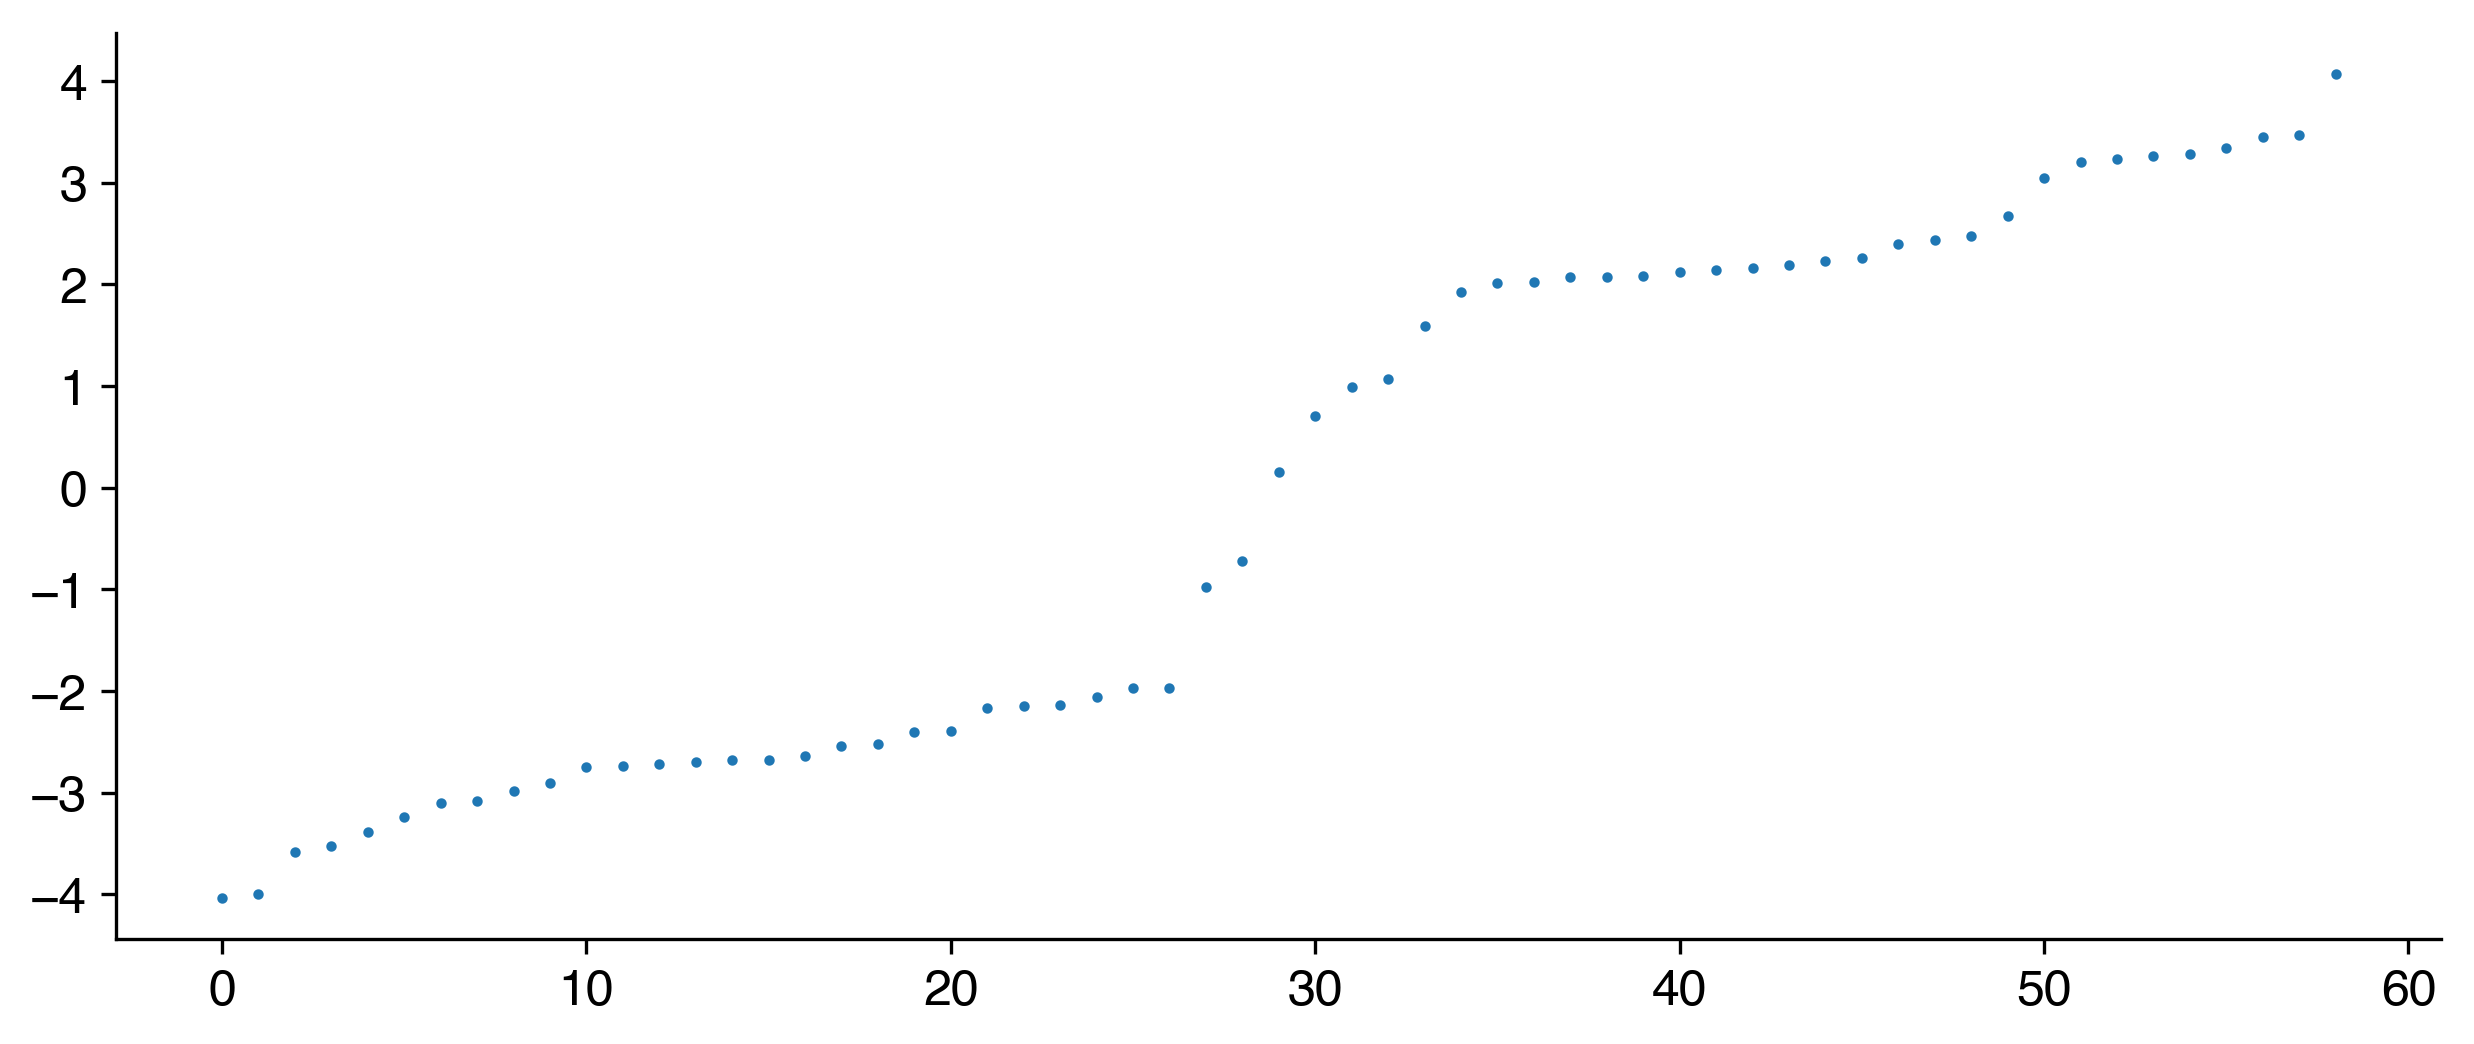

In [40]:
# To what extent are trial category cells encoding one game state or the other?
_df = (ols_weights.query("(subj_sess_unit=={}) & (model=='full') & (factor=='gameState')".format(sig_cells['gameState']))
                  .groupby("subj_sess_unit")['z_weight']
                  .apply(lambda x: 1 * x))
print(count_pct(_df>0) + ' neurons with a main effect of navigation category fire more in Encoding than Retrieval',
      '(p = {:.6f}, binomial test)'.format(stats.binom_test(np.count_nonzero(_df>0), len(_df), 0.5)))
plt.plot(_df.sort_values().values, marker='.', linewidth=0)

In [ ]:
def _merge_dfs():
    level = 'level-{}'.format(factor)
    level_weight = level + '-z_weight'
    if level in mod_pairs:
        mod_pairs.drop(columns=level, inplace=True)
    if level_weight in mod_pairs:
        mod_pairs.drop(columns=level_weight, inplace=True)
        
    return (pd.merge(mod_pairs, _df.rename(columns={'model': 'full', 'factor': 'testvar'}),
                     on=['subj_sess_unit', 'full', 'testvar'], how='left')
            .rename(columns={'level': level, 'z_weight': level_weight}))

In [441]:
# How many cells preferentially encode each level
# of a given variable of interest?
mod_name = 'full'
factor = 'gameState:time'
merge_mod_pairs = True

qry = "(subj_sess_unit=={}) & (model=='{}') & (factor=='{}')"
levels = ols_weights.query(qry.format(sig_cells[factor], mod_name, factor.replace('max-', '')))['level'].drop_duplicates().values

_df = (ols_weights.query(qry.format(sig_cells[factor], mod_name, factor.replace('max-', '')))
                  .groupby(['subj_sess_unit', 'model', 'factor'], sort=False, observed=True)
                  .agg({'z_weight': [lambda x: levels[np.argmax(np.abs(x))], lambda x: np.array(x)[np.argmax(np.abs(x))]]})
                  .reset_index())
_df.columns = ['subj_sess_unit', 'model', 'factor', 'level', 'z_weight']
_df['level'] = _df['level'].astype(pd.CategoricalDtype(levels, ordered=True))
if merge_mod_pairs:
    mod_pairs = _merge_dfs()
    
print('{} – {}; P = {:.6f}, binomial test'.format(factor,
                                                  count_pct(_df['z_weight']>0),
                                                  stats.binom_test(np.count_nonzero(_df['z_weight']>0), len(_df), 0.5)),
      end='\n'*2)
(_df.groupby('level', observed=False)
    .agg({'subj_sess_unit' : lambda x: '{:>2}/{:>2} ({:.1%})'.format(len(x), len(_df), len(x)/len(_df)),
          'z_weight'       : [lambda x: mean_sem(np.abs(x)), lambda x: count_pct(x>0)]}))

gameState:time – 39/64 (60.9%); P = 0.103422, binomial test



/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


subj_sess_unit     z_weight               
                                 <lambda>   <lambda_0>     <lambda_1>
level                                                                
gameState_Encoding:time_1   18/64 (28.1%)  3.51 ± 0.20  14/18 (77.8%)
gameState_Encoding:time_2    9/64 (14.1%)  3.48 ± 0.23    6/9 (66.7%)
gameState_Encoding:time_3     4/64 (6.2%)  2.82 ± 0.20    1/4 (25.0%)
gameState_Encoding:time_4     1/64 (1.6%)   2.42 ± nan   1/1 (100.0%)
gameState_Encoding:time_5            None         None           None
gameState_Encoding:time_6     1/64 (1.6%)   2.65 ± nan   1/1 (100.0%)
gameState_Encoding:time_7     4/64 (6.2%)  2.89 ± 0.11    2/4 (50.0%)
gameState_Encoding:time_8    9/64 (14.1%)  2.89 ± 0.16    6/9 (66.7%)
gameState_Encoding:time_9     5/64 (7.8%)  2.85 ± 0.16    2/5 (40.0%)
gameState_Encoding:time_10  13/64 (20.3%)  2.98 ± 0.16   6/13 (46.2%)

In [437]:
# How many cells preferentially encode each level
# of a given variable of interest?
mod_name = 'full'
factor = 'place'
merge_mod_pairs = True

qry = "(subj_sess_unit=={}) & (model=='{}') & (factor=='{}')"
levels = ols_weights.query(qry.format(sig_cells[factor], mod_name, factor.replace('max-', '')))['level'].drop_duplicates().values

_df = (ols_weights.query(qry.format(sig_cells[factor], mod_name, factor.replace('max-', '')))
                  .groupby(['subj_sess_unit', 'model', 'factor'], sort=False, observed=True)
                  .agg({'z_weight': [lambda x: levels[np.argmax(np.abs(x))], lambda x: np.array(x)[np.argmax(np.abs(x))]]})
                  .reset_index())
_df.columns = ['subj_sess_unit', 'model', 'factor', 'level', 'z_weight']
_df['level'] = _df['level'].astype(pd.CategoricalDtype(levels, ordered=True))
if merge_mod_pairs:
    mod_pairs = _merge_dfs()

print('{} – {}; P = {:.6f}, binomial test'.format(factor,
                                                  count_pct(_df['z_weight']>0),
                                                  stats.binom_test(np.count_nonzero(_df['z_weight']>0), len(_df), 0.5)),
      end='\n'*2)
(_df.groupby('level', observed=False)
    .agg({'subj_sess_unit' : lambda x: '{:>2}/{:>2} ({:.1%})'.format(len(x), len(_df), len(x)/len(_df)),
          'z_weight'       : [lambda x: mean_sem(np.abs(x)), lambda x: count_pct(x>0)]}))

place – 44/60 (73.3%); P = 0.000394, binomial test



/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


subj_sess_unit     z_weight               
                      <lambda>   <lambda_0>     <lambda_1>
level                                                     
place_Base       31/60 (51.7%)  3.71 ± 0.17  21/31 (67.7%)
place_C_Hall       2/60 (3.3%)  2.91 ± 0.06   2/2 (100.0%)
place_NE_Hall      1/60 (1.7%)   2.80 ± nan   1/1 (100.0%)
place_NE_Room      1/60 (1.7%)   3.40 ± nan   1/1 (100.0%)
place_NW_Hall      3/60 (5.0%)  3.16 ± 0.43   3/3 (100.0%)
place_NW_Room      1/60 (1.7%)   5.38 ± nan   1/1 (100.0%)
place_N_Passage    3/60 (5.0%)  2.68 ± 0.44   3/3 (100.0%)
place_SE_Hall     7/60 (11.7%)  2.77 ± 0.23    6/7 (85.7%)
place_SE_Room      2/60 (3.3%)  4.54 ± 1.45   2/2 (100.0%)
place_SW_Hall      2/60 (3.3%)  2.38 ± 0.23   2/2 (100.0%)
place_SW_Room             None         None           None
place_S_Passage   7/60 (11.7%)  2.45 ± 0.18    2/7 (28.6%)

In [439]:
# How many cells preferentially encode each level
# of a given variable of interest?
mod_name = 'full'
factor = 'time:place'
merge_mod_pairs = True

qry = "(subj_sess_unit=={}) & (model=='{}') & (factor=='{}')"
levels = ols_weights.query(qry.format(sig_cells[factor], mod_name, factor.replace('max-', '')))['level'].drop_duplicates().values

_df = (ols_weights.query(qry.format(sig_cells[factor], mod_name, factor.replace('max-', '')))
                  .groupby(['subj_sess_unit', 'model', 'factor'], sort=False, observed=True)
                  .agg({'z_weight': [lambda x: levels[np.argmax(np.abs(x))], lambda x: np.array(x)[np.argmax(np.abs(x))]]})
                  .reset_index())
_df.columns = ['subj_sess_unit', 'model', 'factor', 'level', 'z_weight']
_df['level'] = _df['level'].astype(pd.CategoricalDtype(levels, ordered=True))
if merge_mod_pairs:
    mod_pairs = _merge_dfs()
    
print('{} – {}; P = {:.6f}, binomial test'.format(factor,
                                                  count_pct(_df['z_weight']>0),
                                                  stats.binom_test(np.count_nonzero(_df['z_weight']>0), len(_df), 0.5)),
      end='\n'*2)
(_df.groupby('level', observed=True)
    .agg({'subj_sess_unit' : lambda x: '{:>2}/{:>2} ({:.1%})'.format(len(x), len(_df), len(x)/len(_df)),
          'z_weight'       : [lambda x: mean_sem(np.abs(x)), lambda x: count_pct(x>0)]}))

time:place – 36/43 (83.7%); P = 0.000009, binomial test



/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


subj_sess_unit     z_weight              
                             <lambda>   <lambda_0>    <lambda_1>
level                                                           
time_1:place_Base         3/43 (7.0%)  6.06 ± 0.39  3/3 (100.0%)
time_3:place_Base         2/43 (4.7%)  5.69 ± 0.93  2/2 (100.0%)
time_5:place_Base         1/43 (2.3%)   4.71 ± nan  1/1 (100.0%)
time_9:place_Base         1/43 (2.3%)   2.76 ± nan    0/1 (0.0%)
time_7:place_NE_Hall      1/43 (2.3%)   2.42 ± nan  1/1 (100.0%)
time_3:place_NE_Room      1/43 (2.3%)   2.76 ± nan    0/1 (0.0%)
time_4:place_NE_Room      1/43 (2.3%)   3.18 ± nan  1/1 (100.0%)
time_5:place_NE_Room      1/43 (2.3%)   2.91 ± nan  1/1 (100.0%)
time_8:place_NE_Room      1/43 (2.3%)   4.08 ± nan  1/1 (100.0%)
time_1:place_NW_Hall      1/43 (2.3%)   3.06 ± nan  1/1 (100.0%)
time_10:place_NW_Hall     1/43 (2.3%)  10.02 ± nan  1/1 (100.0%)
time_5:place_NW_Room      1/43 (2.3%)   3.02 ± nan  1/1 (100.0%)
time_8:place_NW_Room      3/43 (7.0%)  4.22 ± 0.64   2/3 (66.7%)
time_10:place_NW_Room     1/43 (2.3%)   4.85 ± nan  1/1 (100.0%)
time_3:place_N_Passage    1/43 (2.3%)   3.29 ± nan  1/1 (100.0%)
time_4:place_N_Passage    1/43 (2.3%)   3.42 ± nan  1/1 (100.0%)
time_6:place_N_Passage    1/43 (2.3%)   2.56 ± nan  1/1 (100.0%)
time_2:place_SE_Hall      1/43 (2.3%)   3.29 ± nan    0/1 (0.0%)
time_5:place_SE_Hall      1/43 (2.3%)   7.74 ± nan  1/1 (100.0%)
time_6:place_SE_Hall      1/43 (2.3%)   4.11 ± nan  1/1 (100.0%)
time_1:place_SE_Room      1/43 (2.3%)   4.61 ± nan    0/1 (0.0%)
time_2:place_SE_Room      4/43 (9.3%)  4.99 ± 0.69  4/4 (100.0%)
time_4:place_SE_Room      1/43 (2.3%)   3.45 ± nan  1/1 (100.0%)
time_5:place_SE_Room      1/43 (2.3%)   3.44 ± nan    0/1 (0.0%)
time_2:place_SW_Hall      2/43 (4.7%)  3.75 ± 0.48   1/2 (50.0%)
time_3:place_SW_Hall      1/43 (2.3%)   4.20 ± nan  1/1 (100.0%)
time_8:place_SW_Hall      1/43 (2.3%)   8.95 ± nan  1/1 (100.0%)
time_9:place_SW_Hall      1/43 (2.3%)   3.31 ± nan  1/1 (100.0%)
time_2:place_SW_Room      2/43 (4.7%)  3.73 ± 0.58  2/2 (100.0%)
time_4:place_SW_Room      1/43 (2.3%)   3.92 ± nan  1/1 (100.0%)
time_10:place_SW_Room     3/43 (7.0%)  4.61 ± 1.46  3/3 (100.0%)

In [245]:
factors = ['icpt', 'gameState', 'time', 'place', 'gameState:time',
           'gameState:place', 'time:place', 'penalty', 'gameState:penalty',
           'time:penalty', 'place:penalty', 'goldDug', 'gameState:goldDug',
           'time:goldDug', 'place:goldDug', 'headDirec', 'isMoving',
           'baseView', 'goldView', 'digAction', 'gameState:headDirec',
           'gameState:isMoving', 'gameState:baseView']
ols_weights['factor'] = ols_weights['factor'].astype(pd.CategoricalDtype(factors, ordered=True))

In [442]:
# gameState      - 'U530_ses1-69-1'
# gameState:time - 'U527_ses0-44-2'
# place          - 'U540_ses0-20-1'
# time:place     - 'U536_ses0-68-1'
subj_sess_unit = 'U527_ses0-58-2'
factors = ['icpt', 'gameState', 'time', 'place', 'gameState:time', 'gameState:place', 'time:place']

display(mod_pairs.query("(subj_sess_unit=='{}')".format(subj_sess_unit)))
display(ols_weights.query("(model=='full') & (subj_sess_unit=='{}')".format(subj_sess_unit))
                   .sort_values(['factor', 'z_weight'], ascending=[True, False]))

# Time fields

In [3]:
reload(time_bin_analysis)

<module 'time_cells.time_bin_analysis' from '/home1/dscho/code/projects/time_cells/time_bin_analysis.py'>

In [7]:
# Find time fields for all significant gameState:time cells.
save_output = 1
overwrite = 0
verbose = False
smooth = 3
n_perm = 1000
thresh = 1.96
max_skips = 1

start_time = time()

for subj_sess_unit in sig_cells['gameState:time']:
    output = time_bin_analysis.bootstrap_time_fields(subj_sess_unit,
                                                     game_states=['Encoding', 'Retrieval'],
                                                     smooth=smooth,
                                                     n_perm=n_perm,
                                                     thresh=thresh,
                                                     max_skips=max_skips,
                                                     save_output=save_output,
                                                     overwrite=overwrite,
                                                     verbose=verbose)
    
print('Done in {:.1f}s'.format(time() - start_time))

Done in 807.8s


In [426]:
mod_pairs.query("(subj_sess_unit=='U527_ses0-58-2')")

,subj_sess_unit,hem,roi,gameState,testvar,full,red,llf_full,llf_red,df,lr,z_lr,emp_pval,sig,sig01,sig_fdr,pvals_fdr,level-gameState:time,level-gameState:time-z_weight,level-place,level-place-z_weight,level-time:place,level-time:place-z_weight
1500,U527_ses0-58-2,L,OF,Encoding-Retrieval,gameState,full,full-gameState,-6298.917126,-6335.835427,1,73.836602,9.540844,0.000999,True,True,False,0.095874,NaN,NaN,NaN,NaN,NaN,NaN
1501,U527_ses0-58-2,L,OF,Encoding-Retrieval,time,full,full-time,-6298.917126,-6301.438416,9,5.042581,-0.731886,0.764236,False,False,False,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1502,U527_ses0-58-2,L,OF,Encoding-Retrieval,gameState:time,full,full-gameState:time,-6298.917126,-6421.702721,9,245.571190,20.132186,0.000999,True,True,True,0.042530,gameState_Encoding:time_2,-5.094338,NaN,NaN,NaN,NaN
1503,U527_ses0-58-2,L,OF,Encoding-Retrieval,place,full,full-place,-6298.917126,-6300.556820,11,3.279388,0.188332,0.220779,False,False,False,0.744198,NaN,NaN,NaN,NaN,NaN,NaN
1504,U527_ses0-58-2,L,OF,Encoding-Retrieval,gameState:place,full,full-gameState:place,-6298.917126,-6318.604574,11,39.374897,0.642627,0.213786,False,False,False,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1505,U527_ses0-58-2,L,OF,Encoding-Retrieval,time:place,full,full-time:place,-6298.917126,-6397.372103,99,196.909955,0.674452,0.233766,False,False,False,0.767641,NaN,NaN,NaN,NaN,NaN,NaN
1506,U527_ses0-58-2,L,OF,Encoding-Retrieval,max-gameState,fullMax,fullMax-gameState,-6278.432585,-6281.601342,1,6.337514,1.221735,0.101898,False,False,False,0.611198,NaN,NaN,NaN,NaN,NaN,NaN
1507,U527_ses0-58-2,L,OF,Encoding-Retrieval,max-time,fullMax,fullMax-time,-6278.432585,-6280.238692,9,3.612214,-0.936910,0.872128,False,False,False,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1508,U527_ses0-58-2,L,OF,Encoding-Retrieval,max-gameState:time,fullMax,fullMax-gameState:time,-6278.432585,-6347.916012,9,138.966854,11.118814,0.000999,True,True,False,0.191748,NaN,NaN,NaN,NaN,NaN,NaN
1509,U527_ses0-58-2,L,OF,Encoding-Retrieval,max-place,fullMax,fullMax-place,-6278.432585,-6280.329992,11,3.794814,0.373975,0.185814,False,False,False,0.810572,NaN,NaN,NaN,NaN,NaN,NaN


In [382]:
def bootstrap_time_fields(subj_sess_unit,
                          game_states,
                          mult=2,
                          smooth=0,
                          n_perm=1000,
                          thresh=2,
                          max_skips=1,
                          proj_dir='/home1/dscho/projects/time_cells',
                          save_output=True,
                          overwrite=False,
                          verbose=True):
    """Return a dataframe of time fields."""
    # Load the saved file if it exists.
    filename = op.join(proj_dir, 'analysis', 'time_fields',
                       '{}-{}-smooth{}-{}perm-zthresh{}-max_skips{}-time_fields.pkl'
                       .format(subj_sess_unit, '_'.join(game_states), smooth, n_perm, thresh, max_skips))
    if op.exists(filename) and not overwrite:
        time_fields = dio.open_pickle(filename)
        return time_fields
    
    # Load the data.
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess,
                                                       proj_dir=proj_dir,
                                                       verbose=False)
    spike_mat = {game_state: event_spikes.get_spike_mat(neuron, game_state).values * mult
                 for game_state in game_states} # trial x time_bin

    # Smooth spike counts over time, separately for each trial and game_state.
    if smooth:
        spike_mat = {game_state: np.array([gaussian_filter1d(spike_mat[game_state][iTrial, :].astype(float), smooth)
                                           for iTrial in range(spike_mat[game_state].shape[0])])
                     for game_state in game_states}

    # Get the mean firing rate in each time bin, across trials.
    mean_frs = {game_state: np.mean(spike_mat[game_state], axis=0)
                for game_state in game_states}

    # Get the null distribution of mean firing rates
    # by circ-shifting spikes within each trial.
    mean_frs_null = {game_state:[] for game_state in game_states}
    for iPerm in range(n_perm):
        spike_mat_null = {game_state: np.array([time_bin_analysis._shift_spikes(spike_mat[game_state][iTrial, :])
                                                for iTrial in range(spike_mat[game_state].shape[0])])
                          for game_state in game_states}
        for game_state in game_states:
            mean_frs_null[game_state].append(np.mean(spike_mat_null[game_state], axis=0))

    # Z-score firing rates.
    z_frs = {game_state: (mean_frs[game_state] - np.mean(mean_frs_null[game_state], axis=0)) / np.std(mean_frs_null[game_state], axis=0)
             for game_state in game_states}

    # Find time fields.
    time_fields = []
    for game_state in game_states:
        _z_frs = z_frs[game_state]

        # Identify positive time fields.
        keep = np.where(np.isfinite(_z_frs))[0]
        while len(keep) > 0:
            field_peak = np.argmax(_z_frs[keep])
            peak_z = np.max(_z_frs[keep])
            field_idx = [field_peak]
            if peak_z > thresh:
                # Scan backwards.
                _idx = field_peak - 1
                skips = 0
                while (_idx in keep) & (skips < max_skips):
                    if _z_frs[_idx] > thresh:
                        field_idx.append(_idx)
                    else:
                        skips += 1
                    _idx -= 1

                # Scan forwards.
                _idx = field_peak + 1
                skips = 0
                while (_idx in keep) & (skips < max_skips):
                    if _z_frs[_idx] > thresh:
                        field_idx.append(_idx)
                    else:
                        skips += 1
                    _idx += 1
                
                # Append the field.
                field_idx = list(np.sort(field_idx))
                time_fields.append([subj_sess_unit, game_state, 'pos',
                                    field_peak, peak_z, len(field_idx), field_idx])
                
                # Remove the field from consideration.
                keep = [x for x in keep if x not in field_idx]
            else:
                break

        # Identify negative time fields.
        keep = np.where(np.isfinite(_z_frs))[0]
        while len(keep) > 0:
            field_peak = np.argmin(_z_frs[keep])
            peak_z = np.min(_z_frs[keep])
            field_idx = [field_peak]
            if peak_z < -thresh:
                # Scan backwards.
                _idx = field_peak - 1
                skips = 0
                while (_idx in keep) & (skips < max_skips):
                    if _z_frs[_idx] < -thresh:
                        field_idx.append(_idx)
                    else:
                        skips += 1
                    _idx -= 1

                # Scan forwards.
                _idx = field_peak + 1
                skips = 0
                while (_idx in keep) & (skips < max_skips):
                    if _z_frs[_idx] < -thresh:
                        field_idx.append(_idx)
                    else:
                        skips += 1
                    _idx += 1

                # Append the field.
                field_idx = list(np.sort(field_idx))
                time_fields.append([subj_sess_unit, game_state, 'neg',
                                    field_peak, peak_z, len(field_idx), field_idx])
                
                # Remove the field from consideration.
                keep = [x for x in keep if x not in field_idx]
            else:
                break

    cols = ['subj_sess_unit', 'gameState', 'field_type',
            'field_peak', 'peak_z', 'field_size', 'field_idx']
    time_fields = pd.DataFrame(time_fields, columns=cols)
    
    # Save the output data.
    if save_output:
        dio.save_pickle(time_fields, filename, verbose)
        
    return time_fields

time_fields: (5, 7)
Done in 2.6s


In [385]:
time_fields

,subj_sess_unit,gameState,field_type,field_peak,peak_z,field_size,field_idx
0,U527_ses0-44-2,Encoding,pos,0,6.977740,11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
1,U527_ses0-44-2,Encoding,neg,33,-2.117312,5,"[32, 33, 34, 35, 36]"
2,U527_ses0-44-2,Retrieval,pos,51,2.722920,8,"[47, 48, 49, 50, 51, 52, 53, 54]"
3,U527_ses0-44-2,Retrieval,neg,16,-2.688628,6,"[14, 15, 16, 17, 18, 19]"
4,U527_ses0-44-2,Retrieval,neg,4,-2.557599,7,"[0, 1, 2, 3, 4, 5, 6]"


In [381]:
time_fields

,subj_sess_unit,gameState,field_type,field_peak,peak_z,field_size,field_idx
0,U527_ses0-44-2,Encoding,pos,0,7.099199,11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
1,U527_ses0-44-2,Encoding,neg,33,-2.174419,5,"[33, 32, 34, 35, 36]"
2,U527_ses0-44-2,Retrieval,pos,50,2.729092,8,"[50, 49, 48, 47, 51, 52, 53, 54]"
3,U527_ses0-44-2,Retrieval,neg,17,-2.681369,6,"[17, 16, 15, 14, 18, 19]"
4,U527_ses0-44-2,Retrieval,neg,3,-2.582507,7,"[3, 2, 1, 0, 4, 5, 6]"


In [364]:
time_fields

,subj_sess_unit,gameState,field_type,field_peak,peak_z,field_size,field_idx
0,U527_ses0-44-2,Encoding,pos,0,6.897688,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
1,U527_ses0-44-2,Encoding,neg,33,6.897688,5,"[32, 33, 34, 35, 36]"
2,U527_ses0-44-2,Retrieval,pos,51,2.749664,8,"[47, 48, 49, 50, 51, 52, 53, 54]"
3,U527_ses0-44-2,Retrieval,neg,17,2.749664,6,"[14, 15, 16, 17, 18, 19]"
4,U527_ses0-44-2,Retrieval,neg,3,2.749664,7,"[0, 1, 2, 3, 4, 5, 6]"


In [353]:
keep

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [344]:
max_fr, max_idx

(6.897688352215925, 0)

In [328]:
spike_mat_null[game_state].shape

(36, 60)

In [329]:
plt.close()
fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=1200)
ax = np.ravel(ax)

for igs, game_state in enumerate(game_states):
    iax = 2 * igs
    ax[iax] = sns.heatmap(spike_mat[game_state], ax=ax[iax])

    iax += 1
    ax[iax] = sns.heatmap(spike_mat_null[game_state], ax=ax[iax])

for iax in range(len(ax)):
    ax[iax].set_xticks([])
    ax[iax].set_yticks([])

fig.tight_layout(pad=0.3)
fig.show()

In [238]:
subj_sess_unit = 'U532_ses0-5-8'
save_output = False
overwrite = False

start_time = time()

mod_pairs, ols_weights = time_bin_analysis.run_ols_nav(subj_sess_unit,
                                                       n_perm=10,
                                                       save_output=save_output,
                                                       overwrite=overwrite)

print('Done in {:.1f}s'.format(time() - start_time))

Done in 61.4s


In [241]:
for mod_name, mod in ols_mods.items():
    print('{:>37}: {:.8f}'.format(mod_name, mod.fit().llf))

                                 full: -5362.71661387
                       full-gameState: -5372.17092340
             full-time,gameState:time: -5402.98056182
                            full-time: -5364.47828771
                  full-gameState:time: -5401.28542530
           full-place,gameState:place: -5373.20828813
                           full-place: -5365.47490005
                 full-gameState:place: -5371.02070907
                      full-time:place: -5403.25224963
                         full+penalty: -5343.58411294
            full+penalty-time:penalty: -5352.39312439
           full+penalty-place:penalty: -5351.50353765
                         full+goldDug: -5316.78722591
            full+goldDug-time:goldDug: -5329.30980141
           full+goldDug-place:goldDug: -5321.69585671
                              fullMax: -5328.67028707
                    fullMax-gameState: -5329.48678419
          fullMax-time,gameState:time: -5353.37901071
                         ful

In [153]:
subj_sess = 'U532_ses0' # 'U527_ses0' # 'U518_ses1'
neuron = '5-8' # '58-2' # '43-2'
verbose = False
game_states = ['Encoding', 'Retrieval']

start_time = time()

# Load session data.
events = events_proc.load_events(subj_sess, proj_dir=data_dir, verbose=verbose)
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=data_dir, verbose=verbose)

# Run models.
warnings.filterwarnings('ignore')
ols_mods, Xy, Xycols, formulas, param_map = get_ols_nav_mods(neuron, events, event_spikes, get_ols_nav_formulas)
# Xy, Xycols, formulas = get_ols_nav_mods(neuron, events, event_spikes, get_ols_nav_formulas)
warnings.resetwarnings()

print('Done in {:.1f}s'.format(time() - start_time))

Done in 3.8s


In [119]:
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=1200)
ax = np.ravel(ax)

iax = 0
_Xy = Xy.copy()
_Xy = _Xy[[col for col in Xy.columns if ':' not in col]]
_Xy.values[np.where(_Xy<0)] = 0
cmat = _Xy.corr()
ax[iax] = sns.heatmap(cmat, vmin=-1, vmax=1, square=True, cbar=False,
                      cmap='RdBu_r', ax=ax[iax])
ax[iax].tick_params(labelsize=5, pad=1)

iax = 1
_Xy = Xy.copy()
_Xy.values[np.where(_Xy<0)] = 0
cmat = _Xy.corr()
ax[iax] = sns.heatmap(cmat, vmin=-1, vmax=1, square=True, cbar=False,
                      cmap='RdBu_r', ax=ax[iax])
ax[iax].tick_params(labelsize=5, pad=1)

fig.show()

In [195]:
full = 'full'
params = ols_mods[full].fit().params
n_params = 0
for k, v in Xycols.items():
    print(k, len(v))
    if k not in ['neuron']:
        n_params += len(v)
print('{} parameters total'.format(n_params))

neuron 1
gameState 1
time 9
place 11
penalty 1
goldDug 1
headDirec 7
isMoving 1
baseView 1
goldView 1
digAction 1
gameState:time 9
gameState:place 11
time:place 99
gameState:penalty 1
time:penalty 9
place:penalty 11
gameState:goldDug 1
time:goldDug 9
place:goldDug 11
gameState:headDirec 7
gameState:isMoving 1
gameState:baseView 1
204 parameters total


In [155]:
for k, v in formulas.items():
    print(k, len(v.split(' + ')))

full 141
full-gameState 140
full-time,gameState:time 123
full-time 132
full-gameState:time 132
full-place,gameState:place 119
full-place 130
full-gameState:place 130
full-time:place 42
full+penalty 163
full+penalty-time:penalty 154
full+penalty-place:penalty 152
full+goldDug 163
full+goldDug-time:goldDug 154
full+goldDug-place:goldDug 152
fullMax 161
fullMax-gameState 160
fullMax-time,gameState:time 143
fullMax-time 152
fullMax-gameState:time 152
fullMax-place,gameState:place 139
fullMax-place 150
fullMax-gameState:place 150
fullMax-time:place 62
fullMax+penalty 183
fullMax+penalty-time:penalty 174
fullMax+penalty-place:penalty 172
fullMax+goldDug 183
fullMax+goldDug-time:goldDug 174
fullMax+goldDug-place:goldDug 172


In [156]:
for mod_name, mod in ols_mods.items():
    print('{:>37}: {:.8f}'.format(mod_name, mod.fit().llf))

                                 full: -5362.71661387
                       full-gameState: -5372.17092340
             full-time,gameState:time: -5402.98056182
                            full-time: -5364.47828771
                  full-gameState:time: -5401.28542530
           full-place,gameState:place: -5373.20828813
                           full-place: -5365.47490005
                 full-gameState:place: -5371.02070907
                      full-time:place: -5403.25224963
                         full+penalty: -5343.58411294
            full+penalty-time:penalty: -5352.39312439
           full+penalty-place:penalty: -5351.50353765
                         full+goldDug: -5316.78722591
            full+goldDug-time:goldDug: -5329.30980141
           full+goldDug-place:goldDug: -5321.69585671
                              fullMax: -5328.67028707
                    fullMax-gameState: -5329.48678419
          fullMax-time,gameState:time: -5353.37901071
                         ful

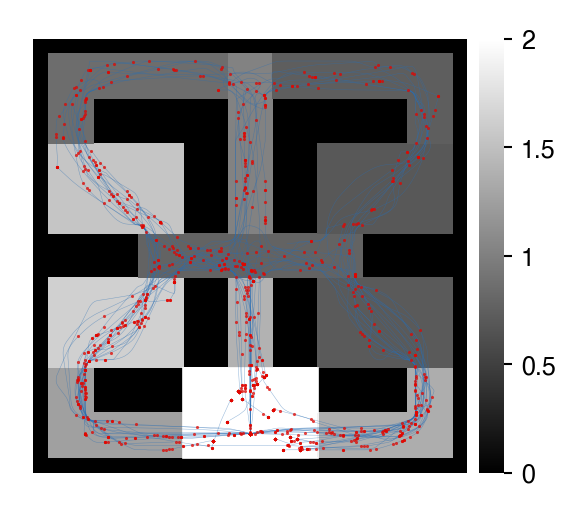

In [98]:
neuron = '8-2'
dpi = 300
font = {'tick': 6, 'label': 7, 'fig': 9}
base_color = 'w'
game_states = ['Encoding']
spikes_when_moving = False

for game_state in game_states:    
    fig, ax = time_cell_plots.plot_firing_maze(subj_sess, 
                                               neuron, 
                                               game_state, 
                                               font=font, 
                                               base_color=base_color,
                                               only_show_spikes_when_moving=spikes_when_moving,
                                               nav_lw=0.12,
                                               nav_color='#296eb4',
                                               nav_alpha=0.5,
                                               spike_marker='.',
                                               spike_fill_color='#e10600',
                                               spike_edge_color='#e10600',
                                               spike_alpha=0.75,
                                               spike_markersize=1.5,
                                               spike_mew=0,
                                               dpi=dpi)
    
fig.show()